#Importing the Data


**Prerequisite:** Download "diabetes_012_health_indicators_BRFSS2015.csv" and "diabetes_binary_health_indicators_BRFSS2015.csv".

In [ ]:
import pandas as pd
import io
from google.colab import files

Importing Ternary Data:

In [ ]:
uploaded1 = files.upload()
ternaryData = pd.read_csv(io.BytesIO(uploaded1['diabetes_012_health_indicators_BRFSS2015.csv']))

Saving diabetes_012_health_indicators_BRFSS2015.csv to diabetes_012_health_indicators_BRFSS2015.csv


Importing Binary Data (optional, make sure you change "ternaryData" to "binaryData" in the code):

In [ ]:
uploaded2 = files.upload()
binaryData = pd.read_csv(io.BytesIO(uploaded2['diabetes_binary_health_indicators_BRFSS2015.csv']))

Importing classifiers (and other tools) to use:

In [ ]:
# numpy, pandas, and seaborn
import numpy as np
import pandas as pd
import seaborn as sns

# splitting the dataset + preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# imported for the process of removing collinear variables:
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Defining the Model

Name all the models we're using in an array (for output purposes) + define important variables

In [ ]:
h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

cv_method = None # default = 5 fold

test_propotion = 0.998
test_threshold = int((1-test_propotion)*ternaryData.shape[0])

Define classifiers and all their respective hyperparameters

In [ ]:
#1.KNN
params_KNN = {
    'n_neighbors':list(range(3, 13)),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
    }

GridSearch_KNN = GridSearchCV(estimator = KNeighborsClassifier(),
                 param_grid=params_KNN, 
                 cv=cv_method,
                 verbose=1, 
                 scoring='accuracy')
#2.SVC
params_SVC = {
    'C': [0.1,1, 10, 100],#Regularization parameter
    'gamma': [1,0.1,0.01,0.001],#Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

GridSearch_SVC = GridSearchCV(estimator=SVC(), 
                 param_grid=params_SVC, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
#3.GaussianProcessClassifier
params_Gaussian = {
    'multi_class' : ['one_vs_rest', 'one_vs_one'],
    'max_iter_predict' : [100,200,300],
    'kernel' : [2.0 * RBF(2.0),3.0 * RBF(3.0)],
}

GridSearch_Gaussian = GridSearchCV(estimator=GaussianProcessClassifier(), 
                 param_grid=params_Gaussian, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')

#4.DecisionTreeClassifier
params_DT = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1,2,3],
    'min_samples_split' : [2,5,10],
}

GridSearch_DT = GridSearchCV(estimator=DecisionTreeClassifier(), 
                 param_grid=params_DT, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')

#5.RandomForestClassifier

params_RF = {
    'max_features' : [1,2,3],
    'max_depth' : [1,2,3,4,5,6,7],
    'n_estimators' : [2,5,10,20],
}

GridSearch_RF = GridSearchCV(estimator=RandomForestClassifier(), 
                 param_grid=params_RF, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')
#6.MLPClassifier

params_MLP = {
    'alpha' : [2,3,4,5],
    'max_iter' : [1000,2000,5000],
}

GridSearch_MLP = GridSearchCV(estimator=MLPClassifier(), 
                 param_grid=params_MLP, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')
#7.AdaBoostClassifier
params_ABC = {
    'algorithm' : ['SAMME', 'SAMME.R'],
    'learning_rate' : [0.01,0.05,0.1],
    'n_estimators' : [20,50,100],
}

GridSearch_ABC = GridSearchCV(estimator=AdaBoostClassifier(), 
                 param_grid=params_ABC, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')

#8.GaussianNB
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
GridSearchNB = GridSearchCV(estimator=GaussianNB(), 
                 param_grid=params_NB, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 

# put all classifiers in one array (used in training and testing the model later)
classifiers = [
    GridSearch_KNN,
    GridSearch_SVC,
    GridSearch_Gaussian,
    GridSearch_DT,
    GridSearch_RF,
    GridSearch_MLP,
    GridSearch_ABC,
    GridSearchNB,
]

#Partitioning the Data

Define function to perform collinear variable removal

In [ ]:
def calculate_vif_(X, thresh=10):
	cols = X.columns
	variables = np.arange(X.shape[1])
	dropped=True
	while dropped:
	    dropped=False
	    c = X[cols[variables]].values
	    vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
	
	    maxloc = vif.index(max(vif))
	    if max(vif) > thresh:
	        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
	        variables = np.delete(variables, maxloc)
	        dropped=True
	
	print('Remaining variables:')
	print(X.columns[variables])
	return X[cols[variables]]

Call calculate_vif_ function and perform data partitioning

dropping 'Education' at index: 20
dropping 'CholCheck' at index: 3
dropping 'AnyHealthcare' at index: 11
dropping 'BMI' at index: 3
dropping 'GenHlth' at index: 11
dropping 'Age' at index: 15
dropping 'Income' at index: 15
dropping 'Veggies' at index: 8
dropping 'PhysActivity' at index: 6
dropping 'HighBP' at index: 1
dropping 'PhysHlth' at index: 9
dropping 'Smoker' at index: 2
dropping 'HighChol' at index: 1
dropping 'Fruits' at index: 3
dropping 'DiffWalk' at index: 6
dropping 'HeartDiseaseorAttack' at index: 2
dropping 'MentHlth' at index: 4
dropping 'Sex' at index: 4
Remaining variables:
Index(['Diabetes_012', 'Stroke', 'HvyAlcoholConsump', 'NoDocbcCost'], dtype='object')


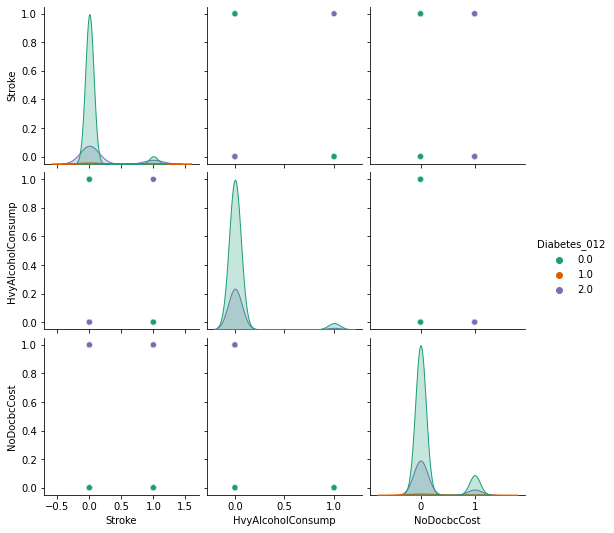

In [ ]:
vif_threshold = 1.1
multi_data_noncollinear = calculate_vif_(ternaryData,thresh=vif_threshold)
sns.pairplot(multi_data_noncollinear.iloc[:test_threshold,:],hue='Diabetes_012',palette='Dark2')


# iterate over classifiers
# VIF above 5 indicates high correlation.
vif_threshold = 5

#multi_data_noncollinear = calculate_vif_(ternaryData,thresh=vif_threshold)
Remaining_variables = ['Diabetes_012', 'HighBP', 'HighChol', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'NoDocbcCost', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Sex']# 15 variables are remaining
multi_data_noncollinear = ternaryData[Remaining_variables]
X_origin = multi_data_noncollinear.to_numpy()[:test_threshold,1:]
y = ternaryData.to_numpy()[:test_threshold,0]
X = StandardScaler().fit_transform(X_origin)

validate_propotion = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validate_propotion, random_state=42)

#Training, Testing, and Output

In [ ]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(name,score,clf.best_estimator_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Nearest Neighbors 0.7745098039215687 KNeighborsClassifier(metric='euclidean', n_neighbors=4)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
SVM 0.7843137254901961 SVC(C=1, gamma=0.1, kernel='sigmoid')
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Gaussian Process 0.7745098039215687 GaussianProcessClassifier(kernel=1.41**2 * RBF(length_scale=2))
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Decision Tree 0.7843137254901961 DecisionTreeClassifier(max_depth=1)
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Random Forest 0.7745098039215687 RandomForestClassifier(max_depth=3, max_features=2, n_estimators=10)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Neural Net 0.7843137254901961 MLPClassifier(alpha=4, max_iter=1000)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
AdaBoost 0.7843137254901961 AdaBoostClassifier(algorithm='SAMME', learning_ra